# ============================================================================
# Import Libraries and Setup
# ============================================================================


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


2025-08-15 06:49:28.802371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755240569.001750      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755240569.056441      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Libraries imported successfully!
TensorFlow version: 2.18.0


# ============================================================================
# Data Generator Class
# ============================================================================


In [2]:
class MNISTDataGenerator:
    """Custom data generator for MNIST dataset with preprocessing and augmentation capabilities"""
    
    def __init__(self, train_path, test_path, validation_split=0.2):
        """Initialize the data generator"""
        self.train_path = train_path
        self.test_path = test_path
        self.validation_split = validation_split
        self.image_shape = (28, 28)
        self.num_classes = 10
        
    def load_and_preprocess_data(self):
        """Load and preprocess the training and test data"""
        print("Loading training data...")
        # Load training data
        train_df = pd.read_csv(self.train_path)
        print(f"Training data shape: {train_df.shape}")
        
        # Separate features and labels from training data
        y_train_full = train_df['label'].values
        X_train_full = train_df.drop('label', axis=1).values
        
        # Normalize pixel values to [0, 1] range
        X_train_full = X_train_full.astype('float32') / 255.0
        
        # Reshape flat pixel vectors to 28x28 images
        X_train_full = X_train_full.reshape(-1, 28, 28, 1)
        
        # Convert labels to categorical (one-hot encoding)
        y_train_full = tf.keras.utils.to_categorical(y_train_full, self.num_classes)
        
        # Split training data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, 
            test_size=self.validation_split, 
            random_state=42, 
            stratify=y_train_full.argmax(axis=1)
        )
        
        print(f"Training set shape: {X_train.shape}")
        print(f"Validation set shape: {X_val.shape}")
        
        # Load and preprocess test data
        print("Loading test data...")
        test_df = pd.read_csv(self.test_path)
        print(f"Test data shape: {test_df.shape}")
        
        X_test = test_df.values.astype('float32') / 255.0
        X_test = X_test.reshape(-1, 28, 28, 1)
        
        return X_train, X_val, y_train, y_val, X_test
    
    def create_data_generators(self, X_train, X_val, y_train, y_val, batch_size=32):
        """Create data generators for training and validation"""
        # Create ImageDataGenerator with data augmentation for training
        train_datagen = ImageDataGenerator(
            rotation_range=10,      # Randomly rotate images by up to 10 degrees
            width_shift_range=0.1,  # Randomly shift width by up to 10%
            height_shift_range=0.1, # Randomly shift height by up to 10%
            zoom_range=0.1,         # Randomly zoom by up to 10%
            fill_mode='nearest'     # Fill empty pixels with nearest values
        )
        
        # Create ImageDataGenerator for validation (no augmentation)
        val_datagen = ImageDataGenerator()
        
        # Create generators
        train_generator = train_datagen.flow(
            X_train, y_train, 
            batch_size=batch_size, 
            shuffle=True
        )
        
        val_generator = val_datagen.flow(
            X_val, y_val, 
            batch_size=batch_size, 
            shuffle=False
        )
        
        return train_generator, val_generator

print("✅ MNISTDataGenerator class defined successfully!")


✅ MNISTDataGenerator class defined successfully!


# ============================================================================
# Model Architecture Functions
# ============================================================================


In [3]:
def create_mlp_model(input_shape=(28, 28, 1), num_classes=10):
    """Create a Multi-Layer Perceptron (MLP) model for digit classification"""
    model = Sequential([
        # Flatten the 28x28 images to 784-dimensional vectors
        tf.keras.layers.Flatten(input_shape=input_shape),
        
        # First hidden layer with 512 neurons
        Dense(512, activation='relu', name='hidden_1'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second hidden layer with 256 neurons
        Dense(256, activation='relu', name='hidden_2'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Third hidden layer with 128 neurons
        Dense(128, activation='relu', name='hidden_3'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer with 10 neurons (one for each digit)
        Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

def compile_model(model, learning_rate=0.001):
    """Compile the model with optimizer, loss, and metrics"""
    # Use Adam optimizer with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',  # Multi-class classification loss
        metrics=['accuracy']              # Track accuracy during training
    )
    
    return model

def create_callbacks():
    """Create callbacks for training"""
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',     # Monitor validation accuracy
            patience=10,                # Stop if no improvement for 10 epochs
            restore_best_weights=True,  # Restore weights from best epoch
            verbose=1
        ),
        
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',         # Monitor validation loss
            factor=0.5,                 # Reduce LR by half
            patience=5,                 # Wait 5 epochs before reducing
            min_lr=1e-7,               # Minimum learning rate
            verbose=1
        ),
        
        # Save best model weights
        ModelCheckpoint(
            'best_mnist_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    return callbacks

print("✅ Model functions defined successfully!")

✅ Model functions defined successfully!



# ============================================================================
# Utility Functions
# ============================================================================



In [4]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def display_sample_images(X_data, y_data, num_samples=10):
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        axes[i].imshow(X_data[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Label: {np.argmax(y_data[i])}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ Utility functions defined successfully!")


✅ Utility functions defined successfully!


# ============================================================================
# Configuration and Data Loading
# ============================================================================


In [5]:
# Hyperparameters (tuned for optimal performance)
BATCH_SIZE = 64          # Batch size for training
LEARNING_RATE = 0.001    # Initial learning rate
EPOCHS = 50              # Maximum number of epochs
VALIDATION_SPLIT = 0.2   # Fraction for validation set

# File paths
TRAIN_PATH = '/kaggle/input/mnist-hw/train.csv'
TEST_PATH = '/kaggle/input/mnist-hw/test.csv'

print("=" * 60)
print("MNIST Digit Classification with Deep Learning")
print("=" * 60)
print(f"Configuration:")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Max epochs: {EPOCHS}")
print(f"  - Validation split: {VALIDATION_SPLIT}")
print("=" * 60)

# Initialize data generator and load data
print("\n🔄 Loading and preprocessing data...")
data_gen = MNISTDataGenerator(TRAIN_PATH, TEST_PATH, VALIDATION_SPLIT)
X_train, X_val, y_train, y_val, X_test = data_gen.load_and_preprocess_data()

print("✅ Data loaded successfully!")

MNIST Digit Classification with Deep Learning
Configuration:
  - Batch size: 64
  - Learning rate: 0.001
  - Max epochs: 50
  - Validation split: 0.2

🔄 Loading and preprocessing data...
Loading training data...
Training data shape: (42000, 785)
Training set shape: (33600, 28, 28, 1)
Validation set shape: (8400, 28, 28, 1)
Loading test data...
Test data shape: (28000, 784)
✅ Data loaded successfully!


# ============================================================================
# Data Exploration (Optional)
# ============================================================================



📊 Data Exploration:
Training set shape: (33600, 28, 28, 1)
Validation set shape: (8400, 28, 28, 1)
Test set shape: (28000, 28, 28, 1)
Label shape: (33600, 10)

🖼️ Sample images from training set:


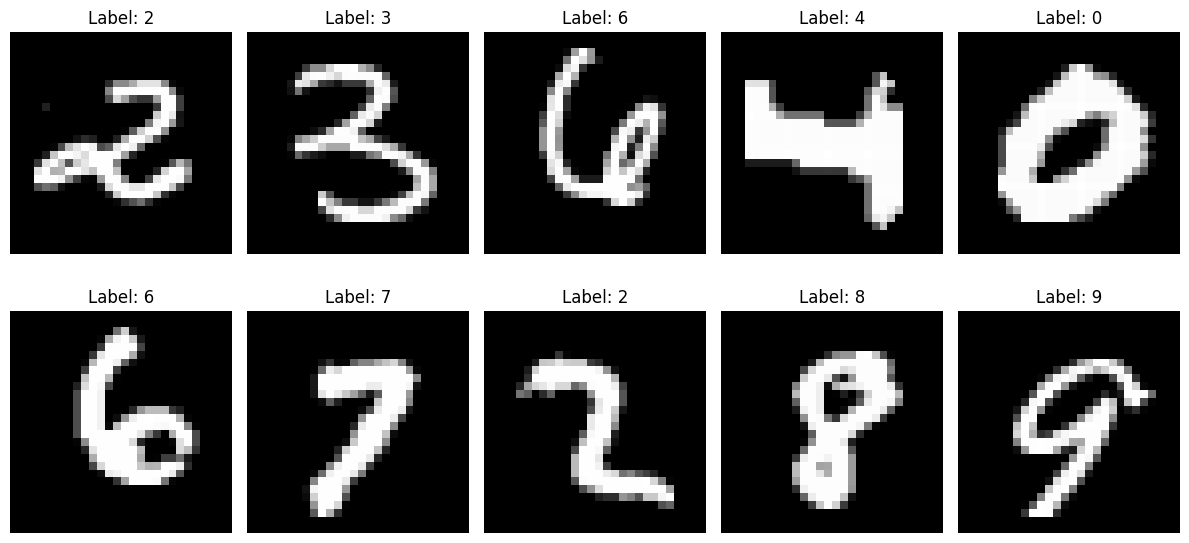


📈 Class distribution in training set:
  Digit 0: 3305 samples (9.8%)
  Digit 1: 3747 samples (11.2%)
  Digit 2: 3342 samples (9.9%)
  Digit 3: 3481 samples (10.4%)
  Digit 4: 3258 samples (9.7%)
  Digit 5: 3036 samples (9.0%)
  Digit 6: 3310 samples (9.9%)
  Digit 7: 3521 samples (10.5%)
  Digit 8: 3250 samples (9.7%)
  Digit 9: 3350 samples (10.0%)


In [6]:

print("\n📊 Data Exploration:")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Label shape: {y_train.shape}")

# Display sample images
print("\n🖼️ Sample images from training set:")
display_sample_images(X_train, y_train, 10)

# Check class distribution
train_labels = np.argmax(y_train, axis=1)
unique, counts = np.unique(train_labels, return_counts=True)
print(f"\n📈 Class distribution in training set:")
for digit, count in zip(unique, counts):
    print(f"  Digit {digit}: {count} samples ({count/len(train_labels)*100:.1f}%)")


# ============================================================================
# Create Data Generators
# ============================================================================


In [7]:

print("\n🔄 Creating data generators with augmentation...")
train_generator, val_generator = data_gen.create_data_generators(
    X_train, X_val, y_train, y_val, BATCH_SIZE
)

print("✅ Data generators created successfully!")
print(f"  - Training generator: {len(X_train)} samples, batch size {BATCH_SIZE}")
print(f"  - Validation generator: {len(X_val)} samples, batch size {BATCH_SIZE}")



🔄 Creating data generators with augmentation...
✅ Data generators created successfully!
  - Training generator: 33600 samples, batch size 64
  - Validation generator: 8400 samples, batch size 64


# ============================================================================
# Build and Compile Model
# ============================================================================


In [8]:
print("\n🏗️ Building and compiling MLP model...")
model = create_mlp_model()
model = compile_model(model, LEARNING_RATE)

print("✅ Model built and compiled successfully!")
print("\n📋 Model Architecture:")
model.summary()


🏗️ Building and compiling MLP model...


I0000 00:00:1755240764.192314      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✅ Model built and compiled successfully!

📋 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,018 (2.18 MB)

 Trainable params: 569,226 (2.17 MB)

 Non-trainable params: 1,792 (7.00 KB)

# ============================================================================
# Train the Model
# ============================================================================


In [9]:

print("\n🚀 Starting model training...")

# Set up callbacks
callbacks = create_callbacks()

# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

print(f"Training configuration:")
print(f"  - Steps per epoch: {steps_per_epoch}")
print(f"  - Validation steps: {validation_steps}")
print(f"  - Callbacks: Early Stopping, LR Reduction, Model Checkpoint")

# Train the model using generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed!")



🚀 Starting model training...
Training configuration:
  - Steps per epoch: 525
  - Validation steps: 131
  - Callbacks: Early Stopping, LR Reduction, Model Checkpoint
Epoch 1/50


I0000 00:00:1755240792.403652     119 service.cc:148] XLA service 0x7f75c0004970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755240792.404545     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755240792.833624     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


 11/525 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1524 - loss: 2.9273 

I0000 00:00:1755240795.561271     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6420 - loss: 1.1277
Epoch 1: val_accuracy improved from -inf to 0.94012, saving model to best_mnist_model.h5
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.6426 - loss: 1.1255 - val_accuracy: 0.9401 - val_loss: 0.1956 - learning_rate: 0.0010
Epoch 2/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8643 - loss: 0.4243
Epoch 2: val_accuracy improved from 0.94012 to 0.96088, saving model to best_mnist_model.h5
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8643 - loss: 0.4243 - val_accuracy: 0.9609 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 3/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8966 - loss: 0.3348
Epoch 3: val_accuracy improved from 0.96088 to 0.96147, saving model to best_mnist_model.h5
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8966 - loss: 0.3348 - val_accuracy: 0.9615 - val_loss: 0.1194 - learning_rate: 0.0010
Epoch 4/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

# ============================================================================
# Evaluate and Visualize Results
# ============================================================================



📊 Plotting training history...


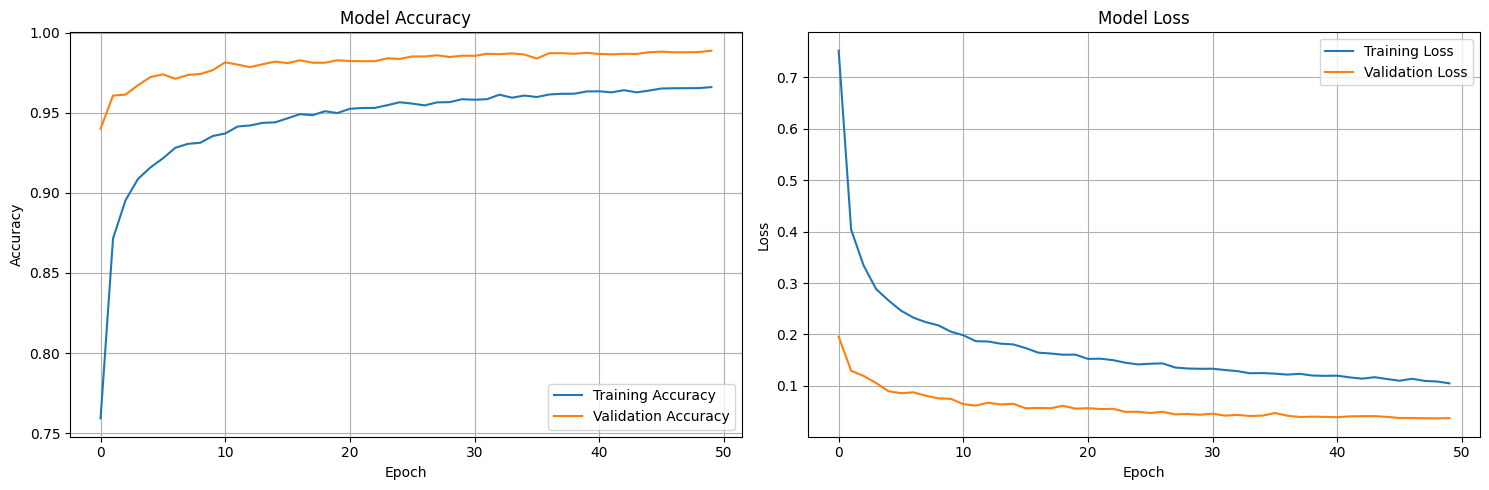


📈 Final evaluation on validation set...
Final Validation Loss: 0.0373
Final Validation Accuracy: 0.9888

📋 Generating detailed classification report...
Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       827
           1       0.99      1.00      0.99       937
           2       0.99      0.99      0.99       835
           3       0.99      0.98      0.98       870
           4       1.00      0.99      0.99       814
           5       0.98      0.98      0.98       759
           6       0.99      1.00      0.99       827
           7       0.98      0.99      0.99       880
           8       0.99      0.99      0.99       813
           9       0.98      0.98      0.98       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



In [10]:
# Plot training history
print("\n📊 Plotting training history...")
plot_training_history(history)

# Final evaluation on validation set
print("\n📈 Final evaluation on validation set...")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Generate detailed classification report
print("\n📋 Generating detailed classification report...")
y_val_pred = model.predict(X_val, verbose=0)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("Detailed Classification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes))


# ============================================================================
# Generate Test Predictions and Submission
# ============================================================================


In [11]:
print("\n🔮 Generating predictions for test set...")
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Create submission file
print("\n💾 Creating submission file...")
submission_df = pd.DataFrame({
    'ImageId': range(1, len(test_predicted_classes) + 1),  # 1-based index
    'Label': test_predicted_classes
})

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print(f"✅ Submission file saved as 'submission.csv'")
print(f"Submission shape: {submission_df.shape}")
print("\n📋 Sample predictions:")
print(submission_df.head(10))

# Save the trained model
print("\n💾 Saving trained model...")
model.save('final_mnist_model.h5')
print("✅ Model saved as 'final_mnist_model.h5'")

print("\n" + "=" * 60)
print("🎉 MNIST Classification Pipeline Completed Successfully!")
print("=" * 60)
print(f"📊 Final Results:")
print(f"  - Validation Accuracy: {val_accuracy:.4f}")
print(f"  - Test Predictions: {len(test_predicted_classes)} samples")
print(f"  - Files Created: submission.csv, final_mnist_model.h5, best_mnist_model.h5")
print("=" * 60)


🔮 Generating predictions for test set...
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

💾 Creating submission file...
✅ Submission file saved as 'submission.csv'
Submission shape: (28000, 2)

📋 Sample predictions:
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3

💾 Saving trained model...
✅ Model saved as 'final_mnist_model.h5'

🎉 MNIST Classification Pipeline Completed Successfully!
📊 Final Results:
  - Validation Accuracy: 0.9888
  - Test Predictions: 28000 samples
  - Files Created: submission.csv, final_mnist_model.h5, best_mnist_model.h5
